# Digital Signal and Image Management
###### Assignment 5

> **Cognome**: Davoli    **Nome**: Sofia                                 \\
> **Matricola**: 813479                                                     \\
                                \\



## Libraries

In [5]:
from tensorflow import keras
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications import vgg16

import numpy as np
import tarfile
from time import time
from shutil import copyfile
import tarfile
import matplotlib.pyplot as plt

## File Reading

In [6]:
# Download del dataset tramite wget
!wget https://www.dropbox.com/s/drwy7fq5svwv78p/101_ObjectCategories_split.tar

--2021-02-15 21:02:26--  https://www.dropbox.com/s/drwy7fq5svwv78p/101_ObjectCategories_split.tar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/drwy7fq5svwv78p/101_ObjectCategories_split.tar [following]
--2021-02-15 21:02:27--  https://www.dropbox.com/s/raw/drwy7fq5svwv78p/101_ObjectCategories_split.tar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdf6acab1912b5297773aad98aa.dl.dropboxusercontent.com/cd/0/inline/BJCh1wOhazpFaKNJgeT1Qw6Hz6RlSz3w_cEFjli3mdSCKTQM3XEH6p5c3UPkcV9jTWTENogMgwlUx_JK4YNSgQS3RJoCknd6JGJVCwUp2nThlUYLRzLkdr7FZaTM2VnI3eQ/file# [following]
--2021-02-15 21:02:28--  https://ucdf6acab1912b5297773aad98aa.dl.dropboxusercontent.com/cd/0/inline/BJCh1wOhazpFaKNJgeT1Qw6Hz6RlSz3w_cEFjli3mdSCKTQM3XEH6p5

In [7]:
tar = tarfile.open('101_ObjectCategories_split.tar')
tar.extractall()
tar.close()

## Data Augmentation
Train and Test generator Preprocesing: 
- featurewise_center transforms the images to 0 mean
- 180 Degree range for random rotations
- width_shift_range and height_shift_range randomly crop the picture by slicing the image
-. Points outside the boundaries of the input are filledas 0 (cval parameters, fill_mode=constant)
- allowing random flip



In [41]:
train_processing =  tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_std_normalization=True,
    rotation_range=180,
    width_shift_range=[-1, 0, +1],
    height_shift_range=[-1, 0, +1],
    brightness_range=[0, 0.7],
    fill_mode="constant",
    cval=0,
    horizontal_flip=True,
    vertical_flip=True , 
    data_format="channels_last",
)

train_generator = train_processing.flow_from_directory('101_ObjectCategories_split/train', 
                                                       target_size = (224, 224), 
                                                       batch_size = 450,
                                                       seed = 1, 
                                                       shuffle = True)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 4600 images belonging to 102 classes.


In [42]:
test_processing =  tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_std_normalization=True,
    rotation_range=180,
    width_shift_range=[-1, 0, +1] ,
    height_shift_range=[-1, 0, +1],
    brightness_range=[0, 0.7],
    fill_mode="constant",
    cval=0,
    horizontal_flip=True,
    vertical_flip=True , 
    data_format="channels_last",
)

test_generator = train_processing.flow_from_directory('101_ObjectCategories_split/train', 
                                                       target_size = (224, 224), 
                                                       batch_size =450,
                                                       seed = 1, 
                                                       shuffle = True)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 4600 images belonging to 102 classes.


## DenseNet121 model_ with augmented data

Model chosen is Dense Net121.

Pooling mode for feature extraction chosen is avg which means that global average pooling will be applied to the output of the last convolutional block, and thus the output of the model will be a 2D tensor. To this 2 other layer will be added.

Wheight are those pre-trained on ImageNet.


In [63]:
model = tf.keras.applications.DenseNet121(include_top = False,
                    weights = 'imagenet', 
                    pooling = 'avg',
                    input_shape = (224, 224, 3))

29089792/29084464 [==============================] - 0s 0us/step


In [64]:
for layer in model.layers:
  layer.trainable = False

The model is completed with 2 Dense layer with 3000-102 layers respectively. Function for first dense layer added is relu and the last one is softmax which converts a real vector to a vector of categorical probabilities (this is why it need 102 neurons).

The resulting net is 428 layer long .

Moreover an early stop check on loss function is made.

In [65]:
x = model.output                                          
x = keras.layers.Dense(3000, activation = 'relu')(x)      
pred = keras.layers.Dense(102, activation = 'softmax')(x) 

In [66]:
net = keras.Model(inputs  = model.input,
                  outputs = pred)

In [67]:
net.compile(loss = keras.losses.categorical_crossentropy,
            optimizer = keras.optimizers.RMSprop(),
            metrics = ['accuracy'])

early = EarlyStopping(monitor = 'val_loss',
                      patience = 6,
                      verbose = 1)

In [68]:
len(model.layers)

428

In [69]:
history = net.fit(train_generator,
                  epochs = 10,
                  validation_data = test_generator,
                  callbacks = early),

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/10
11/11 [==============================] - 129s 12s/step - loss: 16.5084 - accuracy: 0.0442 - val_loss: 5.9757 - val_accuracy: 0.0793
Epoch 2/10
11/11 [==============================] - 116s 11s/step - loss: 5.3065 - accuracy: 0.1115 - val_loss: 4.3926 - val_accuracy: 0.2007
Epoch 3/10
11/11 [==============================] - 117s 11s/step - loss: 4.7699 - accuracy: 0.1893 - val_loss: 3.5120 - val_accuracy: 0.2591
Epoch 4/10
11/11 [==============================] - 117s 11s/step - loss: 3.5229 - accuracy: 0.2644 - val_loss: 3.3475 - val_accuracy: 0.2546
Epoch 5/10
11/11 [==============================] - 117s 11s/step - loss: 3.4363 - accuracy: 0.2790 - val_loss: 3.4019 - val_accuracy: 0.2909
Epoch 6/10
11/11 [==============================] - 116s 11s/step - loss: 3.1939 - accuracy: 0.3097 - val_loss: 3.4483 - val_accuracy: 0.3130
Epoch 7/10
11/11 [==============================] - 117s 11s/step - loss: 3.2820 - accuracy: 0.3278 - val_loss: 2.5746 - val_accuracy: 0.3902
Epoch

In [71]:
net.save('/drive/MyDrive/model_a5.h5')

In [72]:
net.evaluate(test_generator)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


11/11 [==============================] - 58s 5s/step - loss: 2.2470 - accuracy: 0.4633


[2.2470052242279053, 0.46326085925102234]

This model reaches an accuracy of 0.39 on training set after 10 epochs. Even if this result is not satisfying, this is probably due to the lenght of the Net and to the reducted number of epochs of training. This net require a lot of computational effort and time.

Surprisingly the net achieved better result on test set, reaching an accuracy of 0.46.

## Model no augmentation

In [73]:
train_processing = kimage.ImageDataGenerator()

train_generator = train_processing.flow_from_directory('101_ObjectCategories_split/train', 
                                                       target_size = (224, 224), 
                                                       batch_size = 100,
                                                       seed = 1, 
                                                       shuffle = True)

Found 4600 images belonging to 102 classes.


In [74]:
test_processing = kimage.ImageDataGenerator()

test_generator = test_processing.flow_from_directory('101_ObjectCategories_split/test', 
                                                     target_size = (224, 224), 
                                                     batch_size = 100,
                                                     seed = 1, 
                                                     shuffle = True)

Found 4544 images belonging to 102 classes.


In [75]:
x = model.output                                          
x = keras.layers.Dense(3000, activation = 'relu')(x)      
pred = keras.layers.Dense(102, activation = 'softmax')(x) 

In [76]:
net_noag = keras.Model(inputs  = model.input,
                       outputs = pred)

In [77]:
net_noag.compile(loss = keras.losses.categorical_crossentropy,
                 optimizer = keras.optimizers.RMSprop(),
                 metrics = ['accuracy'])

In [78]:
history_noag = net.fit(train_generator,
                       epochs = 10,
                       validation_data = test_generator,
                       callbacks = early);

Epoch 1/10
46/46 [==============================] - 26s 558ms/step - loss: 4.5636 - accuracy: 0.2854 - val_loss: 3.2413 - val_accuracy: 0.3451
Epoch 2/10
46/46 [==============================] - 25s 544ms/step - loss: 2.7146 - accuracy: 0.3998 - val_loss: 2.9395 - val_accuracy: 0.3900
Epoch 3/10
46/46 [==============================] - 25s 555ms/step - loss: 2.3080 - accuracy: 0.4674 - val_loss: 3.0838 - val_accuracy: 0.4089
Epoch 4/10
46/46 [==============================] - 26s 571ms/step - loss: 2.0303 - accuracy: 0.5054 - val_loss: 2.6775 - val_accuracy: 0.4723
Epoch 5/10
46/46 [==============================] - 27s 581ms/step - loss: 1.7522 - accuracy: 0.5700 - val_loss: 2.7362 - val_accuracy: 0.4802
Epoch 6/10
46/46 [==============================] - 27s 593ms/step - loss: 1.5177 - accuracy: 0.6074 - val_loss: 2.7345 - val_accuracy: 0.4892
Epoch 7/10
46/46 [==============================] - 27s 588ms/step - loss: 1.3399 - accuracy: 0.6502 - val_loss: 2.8778 - val_accuracy: 0.4641

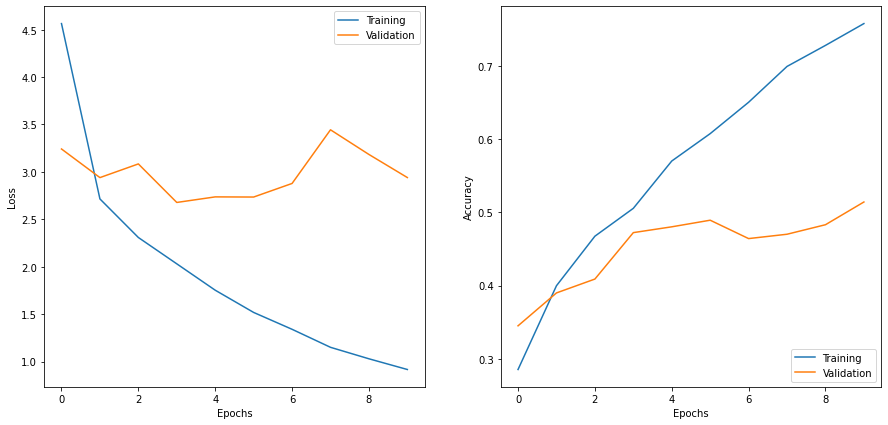

In [79]:
plt.figure(figsize = (15, 7))
ax1 = plt.subplot(121)
plt.xlabel('Epochs')
plt.ylabel('Loss')
ax1.plot(history_noag.history['loss'])
ax1.plot(history_noag.history['val_loss'])
ax1.legend(['Training', 'Validation'])

ax2 = plt.subplot(122)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
ax2.plot(history_noag.history['accuracy'])
ax2.plot(history_noag.history['val_accuracy'])
ax2.legend(['Training', 'Validation'], loc = 'lower right')
plt.show()

In [81]:
net_noag.evaluate(test_generator)

46/46 [==============================] - 14s 299ms/step - loss: 11.5671 - accuracy: 0.0075


[11.567145347595215, 0.007482394576072693]

Without augmented data the model seems to have better performances on training set, but when testing result are terrible. Probably also in this case the training epochs number should be higher.